# Python Text Analysis: Part 2 Solutions

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
%matplotlib inline

In [2]:
# Use pandas to import tweets
tweets_path = '../data/airline_tweets.csv'
tweets = pd.read_csv(tweets_path, sep=',')

## 🥊 Challenge 1: Apply a Text Cleaning Pipeline

Write a function called `preprocess` that performs the following steps on a text input:

* Step 1: Lowercase the text input.
* Step 2: Replace the following patterns with placeholders:
    * URLs &rarr; ` URL `
    * Digits &rarr; ` DIGIT `
    * Hashtags &rarr; ` HASHTAG `
    * Tweet handles &rarr; ` USER `
* Step 3: Remove extra blankspace.

Here are some hints to guide you through this challenge:

* For Step 1, recall from Part 1 that a string method called [`.lower()`](https://docs.python.org/3.11/library/stdtypes.html#str.lower) can be usd to convert text to lowercase. 
* We have integrated Step 2 into a function called `placeholder`. Run the cell below to import it into your notebook, and you can use it just like any other functions.
* For Step 3, we have provided the regex pattern for identifying whitespace characters as well as the correct replacement for extract whitespace. 

Run your `preprocess` function on `example_tweet` (three cells below) to check if it works. If it does, apply it to the entire `text` column in the tweets dataframe.

In [3]:
from utils import placeholder

/workspaces/Python-Text-Analysis/solutions/utils.py:4: SyntaxWarning: invalid escape sequence '\d'
  digit_pattern = '\d+'
/workspaces/Python-Text-Analysis/solutions/utils.py:14: SyntaxWarning: invalid escape sequence '\d'
  digit_pattern = '\d+'


In [4]:
blankspace_pattern = r'\s+'
blankspace_repl = ' '

def preprocess(text):
    '''Create a preprocess pipeline that cleans the tweet data.'''

    # Step 1: Lowercase
    text = text.lower()

    # Step 2: Replace patterns with placeholders
    text = placeholder(text)

    # Step 3: Remove extra whitespace characters
    text = re.sub(blankspace_pattern, blankspace_repl, text)
    text = text.strip()
    
    return text

In [5]:
example_tweet = 'lol @justinbeiber and @BillGates are like soo 2000 #yesterday #amiright saw it on https://twitter.com #yolo'

In [6]:
# Apply the function to the example tweet
print(example_tweet)
print(f"{'='*50}")
print(preprocess(example_tweet))

lol @justinbeiber and @BillGates are like soo 2000 #yesterday #amiright saw it on https://twitter.com #yolo
lol USER and USER are like soo DIGIT HASHTAG HASHTAG saw it on URL HASHTAG


In [7]:
# Apply the function to the text column and assign the preprocessed tweets to a new column
tweets['text_processed'] = tweets['text'].apply(lambda x: preprocess(x))
tweets['text_processed'].head()

0                                 USER what USER said.
1    USER plus you've added commercials to the expe...
2    USER i didn't today... must mean i need to tak...
3    USER it's really aggressive to blast obnoxious...
4        USER and it's a really big bad thing about it
Name: text_processed, dtype: object

## 🥊 Challenge 2: Lemmatize the Text Input

Recall from Part 1 that we introduced using `spaCy` to perform lemmatization, i.e., to "recover" the base form of a word. This process will reduce vocabulary size by keeping word variations minimal—a smaller vocabularly may help improve model performance in sentiment classification. 

Now let's implement lemmatization on our tweet data and use the lemmatized text to create a third DTM. 

Complete the function `lemmatize_text`. It requires a text input and returns the lemmas of all tokens. 

Here are some hints to guide you through this challenge:

- Step 1: initialize a list to hold lemmas
- Step 2: apply the `nlp` pipeline to the input text
- Step 3: iterate over tokens in the processed text and retrieve the lemma of the token
    - HINT: lemmatization is one of the linguistic annotations that the `nlp` pipeline automatically does for us. We can use `token.lemma_` to access the annotation.

In [8]:
# Import spaCy
import spacy
nlp = spacy.load('en_core_web_sm')

In [9]:
# Create a function to lemmatize text
def lemmatize_text(text):
    '''Lemmatize the text input with spaCy annotations.'''

    # Step 1: Initialize an empty list to hold lemmas
    lemma = []

    # Step 2: Apply the nlp pipeline to input text
    doc = nlp(text)

    # Step 3: Iterate over tokens in the text to get the token lemma
    for token in doc:
        lemma.append(token.lemma_)

    # Step 4: Join lemmas together into a single string
    text_lemma = ' '.join(lemma)
    
    return text_lemma

In [10]:
# Apply the function to an example tweet
print(tweets.iloc[101]["text_processed"])
print(f"{'='*50}")
print(lemmatize_text(tweets.iloc[101]['text_processed']))

USER why must a traveler miss a flight to late flight check a bag? i missed my morning appointments and you lost my business. HASHTAG DIGIT lax
USER why must a traveler miss a flight to late flight check a bag ? I miss my morning appointment and you lose my business . HASHTAG DIGIT lax


In [11]:
# This may take a while!
tweets['text_lemmatized'] = tweets['text_processed'].apply(lambda x: lemmatize_text(x))

In [12]:
# Print the preprocessed tweet
print(tweets['text_processed'].iloc[101])
print(f"{'='*50}")
# Print the lemmatized tweet
print(tweets['text_lemmatized'].iloc[101])

USER why must a traveler miss a flight to late flight check a bag? i missed my morning appointments and you lost my business. HASHTAG DIGIT lax
USER why must a traveler miss a flight to late flight check a bag ? I miss my morning appointment and you lose my business . HASHTAG DIGIT lax


## 🥊 Challenge 3: Words with Highest Mean TF-IDF scores

We have obtained tf-idf values for each term in each document. But what do these values tell us about the sentiments of tweets? Are there any words that are  particularly informative for positive/negative tweets? 

To explore this, let's gather the indices of all positive/negative tweets and calculate the mean tf-idf scores of words appear in each category. 

We've provided the following starter code to guide you:
- Subset the `tweets` dataframe according to the `airline_sentiment` label and retrieve the index of each subset (`.index`). Assign the index to `positive_index` or `negative_index`.
- For each subset:
    - Retrieve the td-idf representation 
    - Take the mean tf-idf values across the subset using `.mean()`
    - Sort the mean values in the descending order using `.sort_values()`
    - Get the top 10 terms using `.head()`

Next, run `pos.plot` and `neg.plot` to plot the words with the highest mean tf-idf scores for each subset. 

In [13]:
# Create a tfidf vectorizer
vectorizer = TfidfVectorizer(lowercase=True,
                             stop_words='english',
                             min_df=2,
                             max_df=0.95,
                             max_features=None)

# Fit and transform 
tf_dtm = vectorizer.fit_transform(tweets['text_lemmatized'])

# Create a tf-idf dataframe
tfidf = pd.DataFrame(tf_dtm.todense(),
                     columns=vectorizer.get_feature_names_out(),
                     index=tweets.index)

In [14]:
# Complete the boolean masks 
positive_index = tweets[tweets['airline_sentiment'] == 'positive'].index
negative_index = tweets[tweets['airline_sentiment'] == 'negative'].index

In [15]:
# Complete the following two lines
pos = tfidf.loc[positive_index].mean().sort_values(ascending=False).head(10)
neg = tfidf.loc[negative_index].mean().sort_values(ascending=False).head(10)

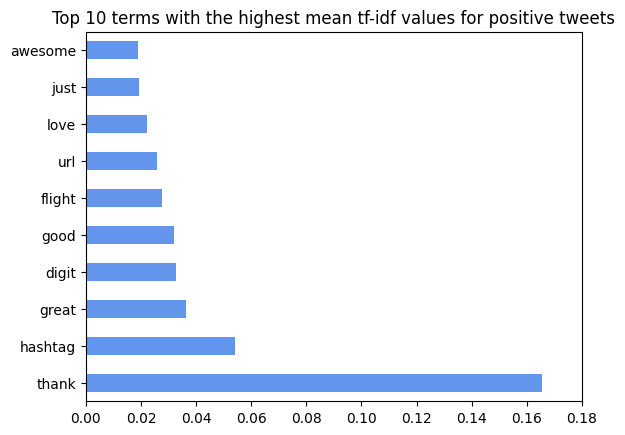

In [16]:
pos.plot(kind='barh', 
         xlim=(0, 0.18),
         color='cornflowerblue',
         title='Top 10 terms with the highest mean tf-idf values for positive tweets');

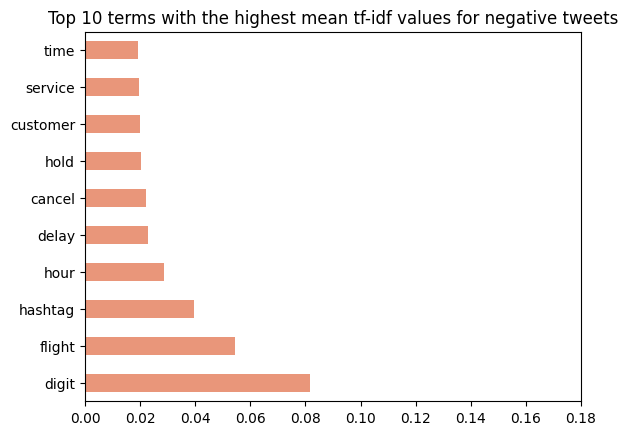

In [17]:
neg.plot(kind='barh', 
         xlim=(0, 0.18),
         color='darksalmon',
         title='Top 10 terms with the highest mean tf-idf values for negative tweets');